<a href="https://colab.research.google.com/github/xxKamilxx/Consumer_complaint_classifier/blob/master/Consumer_complaint_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!unzip -q "/content/drive/My Drive/complaints.csv.zip"

In [1]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

src='complaints.csv'

import pandas as pd
df = pd.read_csv(src)
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
3,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
4,2019-02-08,Vehicle loan or lease,Lease,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,HYUNDAI CAPITAL AMERICA,FL,33161,NaN,Consent not provided,Web,2019-02-08,Closed with non-monetary relief,Yes,NaN,3146310


In [2]:
df.shape

(1606012, 18)

In [3]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.head()

,Product,Consumer complaint narrative
0,Debt collection,transworld systems inc. \nis trying to collect...
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
3,Debt collection,"Over the past 2 weeks, I have been receiving e..."
12,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
13,Debt collection,While checking my credit report I noticed thre...


In [4]:
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
12,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2
13,Debt collection,While checking my credit report I noticed thre...,0


In [0]:
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df


In [0]:
category_to_id = dict(category_id_df.values)
category_to_id

In [7]:
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
id_to_category

{0: 'Debt collection',
 1: 'Credit reporting, credit repair services, or other personal consumer reports',
 2: 'Money transfer, virtual currency, or money service',
 3: 'Mortgage',
 4: 'Student loan',
 5: 'Checking or savings account',
 6: 'Vehicle loan or lease',
 7: 'Credit card or prepaid card',
 8: 'Credit card',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Consumer Loan',
 11: 'Payday loan',
 12: 'Bank account or service',
 13: 'Credit reporting',
 14: 'Other financial service',
 15: 'Money transfers',
 16: 'Prepaid card',
 17: 'Virtual currency'}

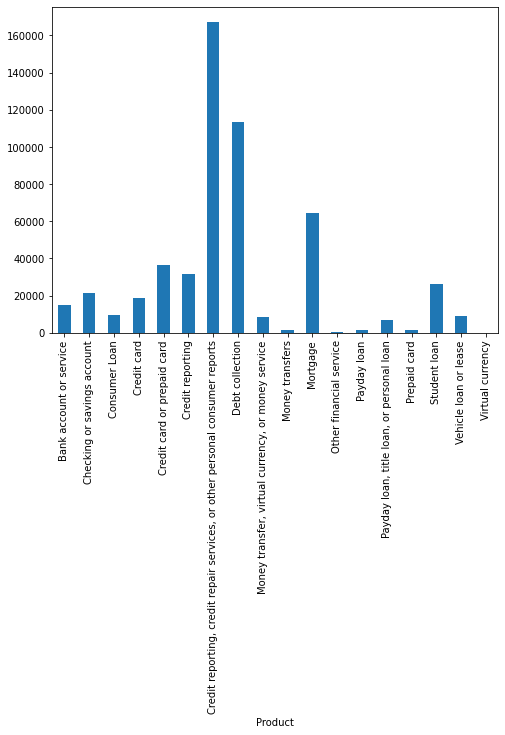

In [8]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
d = df["Consumer_complaint_narrative"].__iter__()
tfidf = TfidfVectorizer(sublinear_tf=True,  #logarithmic form
                        min_df=5,          #min number of documents
                        norm='l2',      #euclidean norm of 1
                        encoding='latin-1', 
                        ngram_range=(1, 2), #indicate unigrams and bigrams
                        stop_words='english') #reduce noisy features
features = tfidf.fit_transform(d)
labels = df.category_id
print(features.shape)

(533635, 917746)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train,x_test,y_train,y_test=train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vec=CountVectorizer()

tfidf_transformer=TfidfTransformer()

clf =MultinomialNB()

In [11]:
from sklearn.pipeline import Pipeline

nb_pipeline = Pipeline([
    ('count_vec',count_vec),
    ('tfidf_transformer',tfidf_transformer),
    ('clf',clf)
])

nb_pipeline.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('count_vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf_transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [0]:
y_pred_nb=nb_pipeline.predict(x_test)

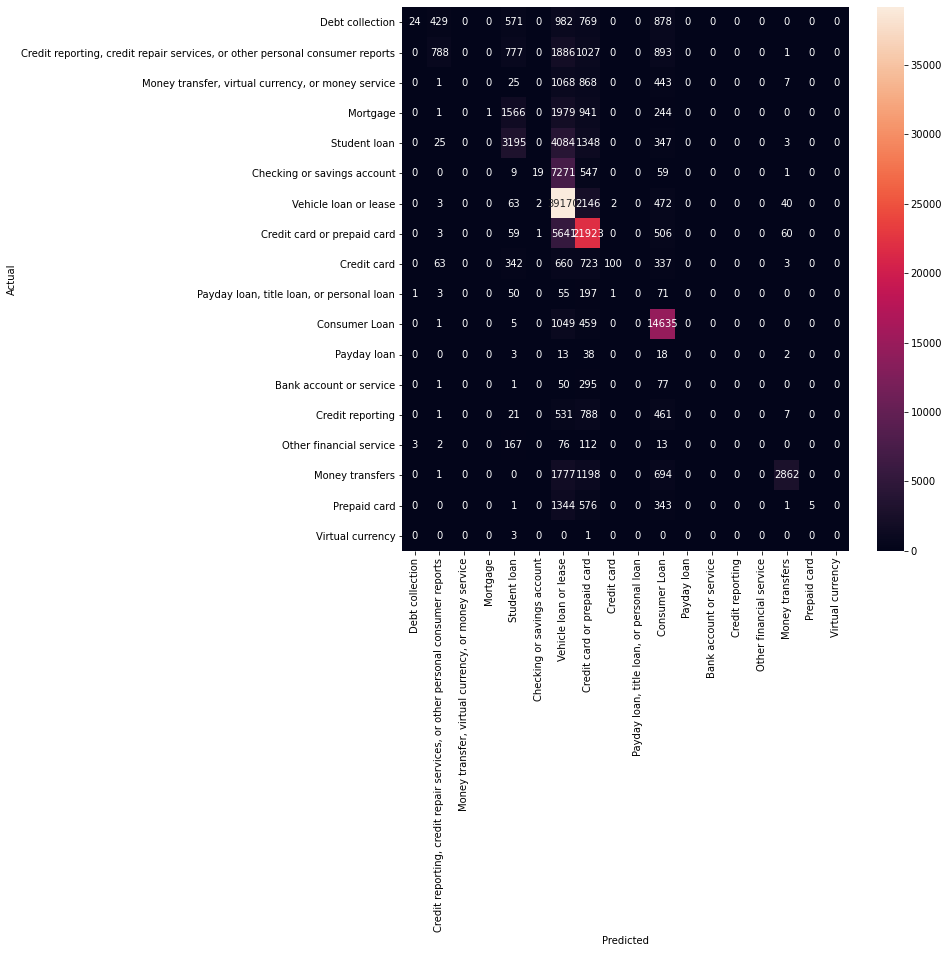

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.86      0.01      0.01      3653
Credit reporting, credit repair services, or other personal consumer reports       0.60      0.15      0.24      5372
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00      2412
                                                                    Mortgage       1.00      0.00      0.00      4732
                                                                Student loan       0.47      0.35      0.40      9002
                                                 Checking or savings account       0.86      0.00      0.00      7906
                                                       Vehicle loan or lease       0.58      0.93      0.72     41898
                                                 Credit

<Figure size 432x288 with 0 Axes>

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from google.colab import files


conf_matrix_nb=confusion_matrix(y_test,y_pred_nb)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred_nb, target_names=df['Product'].unique()))
plt.savefig("/content/drive/My Drive/nb_result.png")


In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

linearSVC= LinearSVC()

svc_pipeline = Pipeline([
    ('count_vec',count_vec),
    ('tfidf_transformer',tfidf_transformer),
    ('linearSVC',linearSVC)
])
param_grid = {'linearSVC__C':[0.1,1,10]}

# svc_pipeline.fit(x_train,y_train)
grid_model=GridSearchCV(svc_pipeline,param_grid,cv=5,return_train_score=True)

grid_model.fit(x_train,y_train)

In [0]:
y_pred_svc=grid_model.predict(x_test)

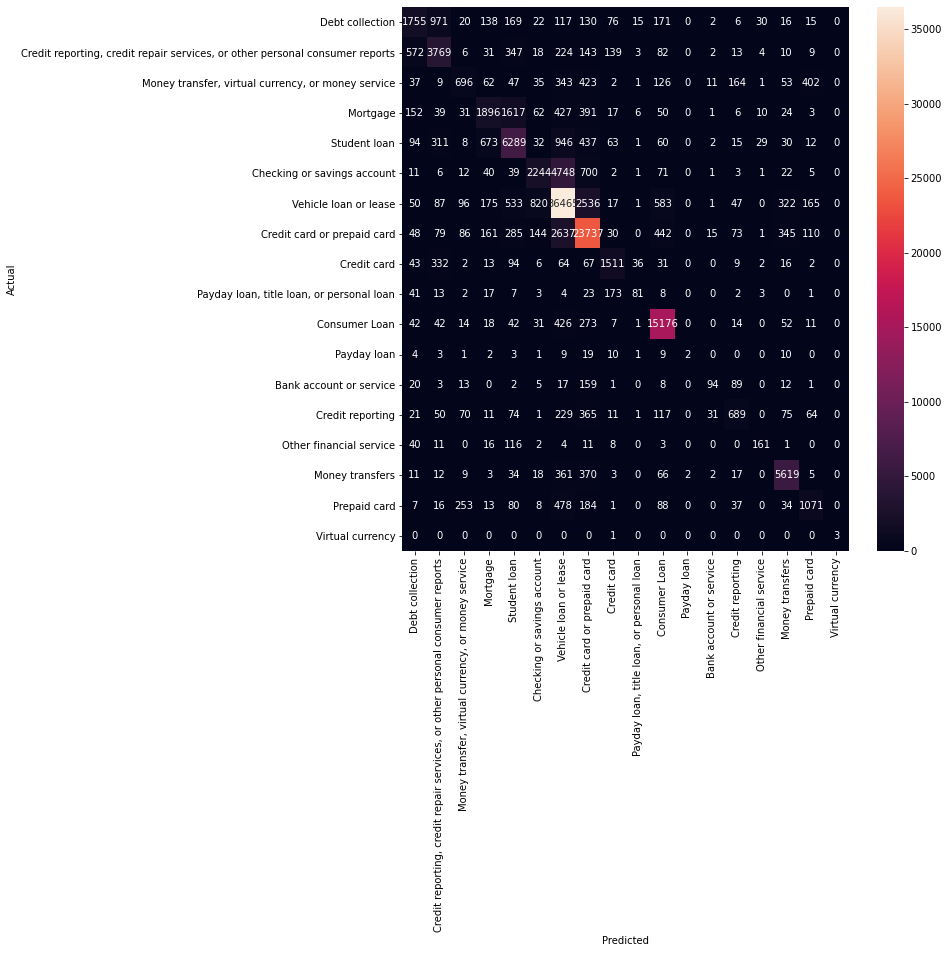

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.60      0.48      0.53      3653
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.70      0.68      5372
                          Money transfer, virtual currency, or money service       0.53      0.29      0.37      2412
                                                                    Mortgage       0.58      0.40      0.47      4732
                                                                Student loan       0.64      0.70      0.67      9002
                                                 Checking or savings account       0.65      0.28      0.40      7906
                                                       Vehicle loan or lease       0.77      0.87      0.82     41898
                                                 Credit

<Figure size 432x288 with 0 Axes>

In [21]:

conf_matrix_svc=confusion_matrix(y_test,y_pred_svc)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(y_test, y_pred_svc, target_names=df['Product'].unique()))
plt.savefig('svc_result.png')
files.download("svc_result.png") 